In [3]:
#地理编码代码

import requests

# 百度地图API密钥
BAIDU_MAP_API_KEY = 'IIIA70lhY1Xx3bV5odDynZOFR9l9o4A7'

def geocode(address):
    boundary_url = f'http://api.map.baidu.com/place/v2/search?query={address}&region=全国&output=json&ak={BAIDU_MAP_API_KEY}'
    boundary_response = requests.get(boundary_url)
    boundary_data = boundary_response.json()
    print(boundary_data)
    if boundary_data['status'] == 0 and boundary_data['results']:
        building_info = boundary_data['results'][0]
        return building_info['location']['lng'],building_info['location']['lat'],building_info['uid']
    else:
        raise Exception('Failed to get building boundary')

if __name__ == '__main__':
    address = "新都区懿润百货"
    lng, lat, poi_id= geocode(address)
    print(poi_id)
    if lng and lat:
        print(f"地址: {address}\n经度: {lng}\n纬度: {lat}")
    else:
        print("地理编码失败")



{'status': 0, 'message': 'ok', 'result_type': 'poi_type', 'query_type': 'precise', 'results': [{'name': '懿润百货(新都店)接送点(懿润百货店)', 'location': {'lat': 30.831186, 'lng': 104.167502}, 'address': '新中路77号（"财富国际购物中心"第壹层的第1E-01号商铺）', 'province': '四川省', 'city': '成都市', 'area': '新都区', 'street_id': '1e326637da25469e6f476027', 'detail': 1, 'uid': '1e326637da25469e6f476027'}, {'name': '懿润百货新都店-东门', 'location': {'lat': 30.831028, 'lng': 104.167574}, 'address': '成都市新都区新中路77号', 'province': '四川省', 'city': '成都市', 'area': '新都区', 'street_id': 'fa06e6cd7ead9aedf4231022', 'detail': 1, 'uid': 'fa06e6cd7ead9aedf4231022'}, {'name': '塔斯汀中国汉堡(新都懿润百货店)', 'location': {'lat': 30.83088, 'lng': 104.167969}, 'address': '桂湖街道新中路66号附3号一层', 'province': '四川省', 'city': '成都市', 'area': '新都区', 'telephone': '18950559082', 'detail': 1, 'uid': 'e674bdc0366e00f82806ce8d'}, {'name': '周六福(懿润百货新都店)', 'location': {'lat': 30.831535, 'lng': 104.167243}, 'address': '四川省成都市新都区桑园街151号-155号', 'province': '四川省', 'city': '成都市', 'area': '新都区', '

Central Building Area: 1284.9368449341575 square meters
Aspect Ratio (East-West / North-South): 0.7131782945736435


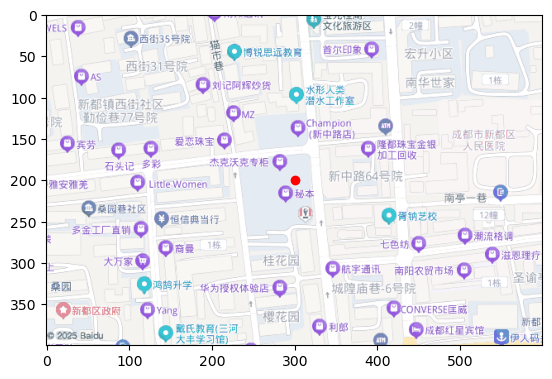

In [6]:
import requests
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

zoom_level = 18

# 设置地图的中心位置和缩放级别
def getpic(lng, lat, zoom_level):
    center_lng, center_lat = lng, lat

    # 获取地图图像
    map_url = f"http://api.map.baidu.com/staticimage/v2?ak=SoZrYEwetEADTCpt4tPKqTomx4aNGupN&center={center_lng},{center_lat}&width=600&height=400&zoom={zoom_level}&copyright=1"
    map_img_data = requests.get(map_url).content

    # 保存地图图像
    with open('map_image.png', 'wb') as f:
        f.write(map_img_data)

    # 在地图上添加标记点
    markers = [(300, 200)]
    for marker in markers:
        marker_lng, marker_lat = marker
        plt.scatter([marker_lng], [marker_lat], c='red', marker='o')

    # 显示地图
    plt.imshow(plt.imread('map_image.png'))

getpic(lng, lat, zoom_level)

def load_image(image_path):
    # 加载图像
    image = cv2.imread(image_path)
    return image

def hex_to_bgr(hex_color): # 将十六进制颜色转换为BGR 
    hex_color = hex_color.lstrip('#') 
    bgr_color = tuple(int(hex_color[i:i+2], 16) for i in (4, 2, 0)) 
    return bgr_color

def get_dominant_color(image, k=4):
    # 将图像转换为数据点
    data = image.reshape((-1, 3))
    data = np.float32(data)

    # 定义KMeans参数
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # 获取中心颜色
    dominant_color = centers[np.argmax(np.bincount(labels.flatten()))]
    return tuple(map(int, dominant_color))

def preprocess_image(image, bgr_color):
    # 转换为HSV图像
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # 将BGR颜色转换为HSV
    bgr_color = np.uint8([[bgr_color]])
    hsv_color = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2HSV)[0][0]
    # 定义颜色范围，留一些色差余地
    lower_color = np.array([hsv_color[0] - 5, max(hsv_color[1] - 5, 0), max(hsv_color[2] - 40, 0)], dtype=np.uint8)
    upper_color = np.array([hsv_color[0] + 5, min(hsv_color[1] + 5, 255), min(hsv_color[2] + 40, 255)], dtype=np.uint8)
    # 根据颜色范围创建掩码
    mask = cv2.inRange(hsv, lower_color, upper_color)
    # 应用掩码
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    # 转换为灰度图像
    gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    # 应用高斯模糊
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # 边缘检测
    edged = cv2.Canny(blurred, 50, 150)
    # 使用形态学操作填补不封闭的轮廓
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    return closed

def find_central_contour(edged, image_shape, min_area=1000):
    # 查找轮廓
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 图像中心点
    image_center = (image_shape[1] // 2, image_shape[0] // 2)
    
    def contour_center(contour):
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            return (cX, cY)
        return (0, 0)
    
    # 过滤掉面积小于 min_area 的轮廓
    valid_contours = [contour for contour in contours if cv2.contourArea(contour) >= min_area]
    
    if not valid_contours:
        raise Exception("No valid contours found")
    
    # 找到距离图像中心最近的有效轮廓
    central_contour = min(valid_contours, key=lambda contour: np.linalg.norm(np.array(contour_center(contour)) - np.array(image_center)))
    return central_contour, np.linalg.norm(np.array(contour_center(central_contour)) - np.array(image_center))

def draw_contour(image, contour):
    # 绘制轮廓
    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
    return image

def calculate_area(contour):
    # 计算轮廓面积
    area = cv2.contourArea(contour)
    zoom_to_scale = {
        19: 20 / 48,
        18: 50 / 61,
        17: 100 / 61
    }
    
    # 获取当前zoom level的像素比例尺
    scale = zoom_to_scale.get(zoom_level)
    if scale is None:
        raise ValueError(f"Unsupported zoom level: {zoom_level}")
    
    # 将像素面积转换为实际面积
    actual_area = area * (scale ** 2)
    return actual_area

def calculate_aspect_ratio(contour):
    # 计算轮廓的外接矩形
    x, y, w, h = cv2.boundingRect(contour)
    # 计算东西走向与南北走向的比率
    aspect_ratio = w / h
    return aspect_ratio

def main(image_path):
    image = load_image(image_path)
    h, w, _ = image.shape
    central_region = image[h*3//7:h*4//7, w*3//7:w*4//7]  # 缩小中央区域
    dominant_color = get_dominant_color(central_region)
    
    # 使用给定颜色进行预处理和轮廓检测
    given_color = hex_to_bgr('f9f7f4')
    edged_given = preprocess_image(image, given_color)
    central_contour_given, distance_given = find_central_contour(edged_given, image.shape)
    
    try:
        # 使用中央主要颜色进行预处理和轮廓检测
        edged_dominant = preprocess_image(image, dominant_color)
        central_contour_dominant, distance_dominant = find_central_contour(edged_dominant, image.shape)
        
        # 选择距离中心点更近的轮廓
        if distance_given < distance_dominant:
            central_contour = central_contour_given
            edged = edged_given
        else:
            central_contour = central_contour_dominant
            edged = edged_dominant
    except Exception as e:
        # 如果使用中央主要颜色找不到轮廓，则使用给定颜色的轮廓
        central_contour = central_contour_given
        edged = edged_given
    
    image_with_contour = draw_contour(image.copy(), central_contour)
    area = calculate_area(central_contour)
    aspect_ratio = calculate_aspect_ratio(central_contour)

    # 显示结果
    cv2.imshow("Original Image", image)
    cv2.imshow("Edged Image", edged)
    cv2.imshow("Central Contour", image_with_contour)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # 打印面积和比率
    print(f"Central Building Area: {area} square meters")
    print(f"Aspect Ratio (East-West / North-South): {aspect_ratio}")

if __name__ == "__main__":
    image_path = "map_image.png"  # 替换为你的图像路径
    main(image_path)

In [5]:
#规模搜索功能

import numpy as np  # 导入数值计算扩展模块
import requests     # 导入网页请求模块
import sqlite3
import time, math

# 创建或连接到本地 SQLite 数据库
db = sqlite3.connect('community.db')
cursor = db.cursor()
# 创建表格
cursor.execute('''
CREATE TABLE IF NOT EXISTS community_zh (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    province TEXT,
    city TEXT,
    area TEXT,
    community TEXT,
    address TEXT,
    lat REAL,
    lng REAL,
    uid TEXT,
    detail INTEGER
)
''')
db.commit()

print("connect successfully, start creating table community_zh in database community\n")

unit = 60 #60*60个栅格
lat_partion = [round(x,6) for x in list(np.linspace(21.874881,22.418767, unit))]    # 维度划分，保留6位小数
lng_partion = [round(y,6) for y in list(np.linspace(113.112379,113.641301, unit))]  # 经度划分，保留6位小数

def get_community():            # 自定义按区域获取小区名称的函数
    for i in range(53, 59):      # 横向栅格索引
        # time.sleep(10)
        for j in range(0, 59):  # 纵向栅格索引
            not_max_page = True # 没有到达最大页面时循环
            page_num = 0        # 从第一页开始

            while not_max_page:
                url = "http://api.map.baidu.com/place/v2/search?query=小区&page_size=20&page_num=" + str(page_num) + \
                "&bounds=" + str(lat_partion[i]) + "," + str(lng_partion[j])+"," + str(lat_partion[i+1]) + "," + str(lng_partion[j+1]) + \
                "&output=json&ak=IIIA70lhY1Xx3bV5odDynZOFR9l9o4A7"  # 构造请求网址,其中你的ak是你要向百度申请的密钥
                print(url)
                header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}  # 构造请求头
                response = requests.get(url, headers = header)  # 发出请求
                time.sleep(1)

                answer = response.json()  # json化
                total = int(answer["total"])
                max_page = math.ceil(total / 20)

                if answer['status'] == 0:  # 如果正常返回
                    print("\n# Rectangle (%d,%d)  Page %s" % (i, j, page_num))
                    print("# Amount: %s" % len(answer['results']))
                    print("# Total: %s" % total)

                    page_num += 1
                    if page_num > max_page:  # 到达最大页时推出循环到下一个单元
                        break

                    for k in range(len(answer['results'])): 
                        province = answer['results'][k]['province']    # 省份
                        if province == "澳门特别行政区":
                            break
                        city = answer['results'][k]['city']            # 城市
                        area = answer['results'][k]['area']            # 区域
                        community = answer['results'][k]['name']       # 小区名称
                        address = answer['results'][k]['address']      # 地址
                        lat = answer['results'][k]['location']['lat']  # 纬度
                        lng = answer['results'][k]['location']['lng']  # 经度
                        uid = answer['results'][k]['uid']              # 唯一标识
                        detail = answer['results'][k]['detail']        # 是否具有详情内容
                        insert_data = ("INSERT INTO community_zh(province, city, area, community, address, lat, lng, uid, detail)""VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s)")
                        community_data = ([province, city, area, community, address, lat, lng, uid, detail])  # 组成一条记录
                        print(community_data)
                        cursor.execute(insert_data, community_data)  # 执行插入操作
                        db.commit()  # 主动提交
                else:
                    print("* The rectangle (%d,%d) contains no community"%(i, j)) 
                    break

        
if __name__=='__main__':
    get_community()

connect successfully, start creating table community_zh in database community

http://api.map.baidu.com/place/v2/search?query=小区&page_size=20&page_num=0&bounds=22.363457,113.112379,22.372675,113.121344&output=json&ak=IIIA70lhY1Xx3bV5odDynZOFR9l9o4A7


KeyError: 'total'

In [19]:
#街景代码

import urllib.request  #打开网页模块
import urllib.parse    #转码模块
import os
import requests

#这里的路径可替换为自己保存文件夹的路径
save_path = r"C:\Users\SineoCardinal\Desktop\chanllenger\streetmap\picture_save/"

ak = "IIIA70lhY1Xx3bV5odDynZOFR9l9o4A7"

#判断文件夹是否存在，若不存在则创建
if not os.path.exists(save_path):
    os.makedirs(save_path)

#替换为你自己制作的txt路径及文件
#从txt文件中读取坐标
# with open(r"C:\Users\SineoCardinal\Desktop\chanllenger\streetmap\location.txt","r",encoding='UTF-8')as f:
#     location = f.readlines()
location=f'{lng},{lat}'
#使用for循环遍历出每个location坐标
# for i in range(len(location)):
#     #使用for循环，每一次都输出[0,1,2,3]这一列表
for j in range(4):

    # # 将列表中的第i个拿出来，并用split划分拿第0个
     # location_number = (location[i].split(';')[0]).replace("\n", "")
    # location_number = location_number.replace(";", "")

    #旋转的角度
    #[0,1,2,3] * 90 = [0,90,180,270]
    heading_number = str(90*j)

    url = r"https://api.map.baidu.com/panorama/v2?" \
        "&width=1024&height=512" \
        "&poiid="+blduid+\
        "&heading="+heading_number+ \
        "&ak=" + ak

    #文件保存名称
    save_name =save_path+str(i)+"."+str(j)+".jpg"
    print(url)
    #打开网页
    rep = urllib.request.urlopen(url)
    #将图片存入本地，创建一个save_name的文件，wb为写入
    f = open(save_name,'wb')
    #写入图片
    f.write(rep.read())
    f.close()
    print('图片保存成功')

https://api.map.baidu.com/panorama/v2?&width=1024&height=512&poiid=67be4009360d6e9f93114cf3&heading=0&ak=IIIA70lhY1Xx3bV5odDynZOFR9l9o4A7
图片保存成功
https://api.map.baidu.com/panorama/v2?&width=1024&height=512&poiid=67be4009360d6e9f93114cf3&heading=90&ak=IIIA70lhY1Xx3bV5odDynZOFR9l9o4A7
图片保存成功
https://api.map.baidu.com/panorama/v2?&width=1024&height=512&poiid=67be4009360d6e9f93114cf3&heading=180&ak=IIIA70lhY1Xx3bV5odDynZOFR9l9o4A7
图片保存成功
https://api.map.baidu.com/panorama/v2?&width=1024&height=512&poiid=67be4009360d6e9f93114cf3&heading=270&ak=IIIA70lhY1Xx3bV5odDynZOFR9l9o4A7
图片保存成功


In [41]:
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import os

# 百度全景图API密钥
BAIDU_PANORAMA_API_KEY = 'IIIA70lhY1Xx3bV5odDynZOFR9l9o4A7'

def get_panorama_image(lng, lat, heading, direction_index, image_index, save_path):
    url = f"http://api.map.baidu.com/panorama/v2?ak={BAIDU_PANORAMA_API_KEY}&width=1024&height=512&location={lng},{lat}&fov=180&heading={heading}"
    response = requests.get(url)
    if response.status_code == 200:
        try:
            image = Image.open(BytesIO(response.content))
            image.save(os.path.join(save_path, f'{direction_index}.{image_index}.jpg'))
            print(f"Saved panorama image as {direction_index}.{image_index}.jpg")
        except UnidentifiedImageError:
            print(f"Failed to identify image for heading {heading} at ({lng}, {lat})")
    else:
        print(f"Failed to get panorama image for heading {heading} at ({lng}, {lat}). Status code: {response.status_code}")

def get_surrounding_points(lng, lat, num_points=3, distance=0.0001):
    # 生成每个方向上的多个点的经纬度
    points = {
        'east': [(lng + distance, lat + (i-3) * distance) for i in range(1, num_points + 1)],
        'west': [(lng - distance, lat + (i-3) * distance) for i in range(1, num_points + 1)],
        'south': [(lng + (i-3) * distance, lat - distance) for i in range(1, num_points + 1)],
        'north': [(lng + (i-3) * distance, lat + distance) for i in range(1, num_points + 1)]
    }
    return points

def clear_directory(directory):
    files = glob.glob(os.path.join(directory, '*'))
    for f in files:
        os.remove(f)
    print(f"Cleared all files in directory: {directory}")

if __name__ == '__main__':
    save_path = r"C:\Users\SineoCardinal\Desktop\chanllenger\wwr\picture_save"
    os.makedirs(save_path, exist_ok=True)

    # 清空目标文件夹中的所有图片
    clear_directory(save_path)

    if lng and lat:
        print(f"经度: {lng}\n纬度: {lat}")
        
        # 获取周围多个点的经纬度
        points = get_surrounding_points(lng, lat)
        
        # 获取每个点的街景图片
        direction_map = {'east': 0, 'west': 1, 'south': 2, 'north': 3}
        for direction, point_list in points.items():
            heading = 0
            if direction == 'east':
                heading = 270  # 朝西
            elif direction == 'west':
                heading = 90  # 朝东
            elif direction == 'south':
                heading = 0  # 朝北
            elif direction == 'north':
                heading = 180  # 朝南
            
            direction_index = direction_map[direction]
            for image_index, point in enumerate(point_list):
                try:
                    get_panorama_image(point[0], point[1], heading, direction_index, image_index, save_path)
                except Exception as e:
                    print(f"Error occurred while processing point ({point[0]}, {point[1]}): {e}")
    else:
        print("地理编码失败")

NameError: name 'glob' is not defined